In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from io import open
import glob
import os, sys
import unicodedata
import string
import time
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from random import randint
from torch.autograd import Variable
import numpy as np
from numpy.random import shuffle
from common import *
# from datasets.hanoi import *

from models.hanoi import *

In [3]:
from numpy.random import normal

def get_samples(size=1, imsize=64, shrink=3/4, 
                baseonly=False, tensor=True, device=None, concat=False):
    batch = []
    for ii in range(size):
        d0 = np.abs(normal(0, 5))
        s0 = imsize - d0
        y0 = max(min(normal((imsize - s0)//2, 1), imsize-s0), 0)
        x0 = max(min(normal((imsize - s0)//2, 1), imsize-s0), 0)
        
        s1 = normal(s0*(shrink), 10)
        s1 = min(s1, s0) # cannot exceed parent
        y1 = max(min(normal((s0 - s1)//2, 5), s0 - s1), 0)
        x1 = max(min(normal((s0 - s1)//2, 5), s0 - s1), 0)
        
        stack = [torch.FloatTensor([x0/imsize, y0/imsize, s0/imsize, s0/imsize]).to(device)]
        if not baseonly:
            stack += [torch.FloatTensor([x1/imsize, y1/imsize, s1/imsize, s1/imsize]).to(device)]
        if concat:
            stack = torch.cat(stack, -1).to(device)
        batch.append(stack)
    return batch

def raster(stack, imsize=64, colors=[1, 0.7]):
    canvas = np.zeros((imsize, imsize))
    yoffset, xoffset = 0, 0
    for ni, node in enumerate(stack):
        xx, yy, sizeX, sizeY = node.detach().cpu().numpy() * imsize
        canvas[
            int(yy+yoffset):int(yy+yoffset+sizeY), 
            int(xx+xoffset):int(xx+xoffset+sizeX)] = colors[ni]
        yoffset += yy
        xoffset += xx
    return canvas

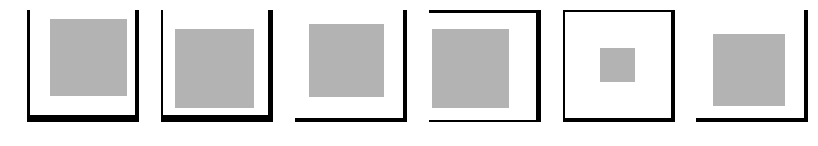

In [4]:
spreview = 6
samples = get_samples(spreview)

plt.figure(figsize=(14, 5))
for ii in range(spreview):
    plt.subplot(1, spreview, ii+1)
    plt.imshow(raster(samples[ii]), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.show()
plt.close()

In [5]:
def tonumpy(torch_stack):
    nplist = []
    for ent in torch_stack:
        nplist.append(ent.detach().cpu().numpy())
    return nplist

def coverage(stack):
    s0, s1 = stack
    ratioX = s1[2] / s0[2]
    ratioY = s1[3] / s0[3]
    return ratioX, ratioY

def centering(stack):
    def center_ratio(possible, actual):
        if possible == 0: return 0
        center = possible / 2
        offset = actual - center
        return offset / center
    
    s0, s1 = stack
    return center_ratio(s0[2] - s1[2], s1[0]), center_ratio(s0[3] - s1[3], s1[1])

def plot_coverage(stack_hist, dim, target=None, plot=True):
    if plot: plt.figure(figsize=(14, 3))
        
#     def plot_dim(dim):
    means = []
    errs = []

    for stage in stack_hist:
        covs = [coverage(tonumpy(stack))[dim] for stack in stage]
        mu = np.mean(covs)
        var = np.var(covs)
        means.append(mu)
        errs.append(var)

    if target is not None:
        plt.plot([-1, len(stack_hist)], [target, target])
    plt.errorbar(np.arange(len(means)), means, yerr=errs, fmt='-o')
    
    if np.min(means) > 0 and np.max(means) < 1:
        plt.ylim(0, 1)
    if plot: plt.show()
    if plot: plt.close()
    
def plot_centering(stack_hist, dim, plot=True):
    means = []
    errs = []
    
    target = 0 # drift w/ reference to center
    for stage in stack_hist:
        covs = [centering(tonumpy(stack))[dim] for stack in stage]
        mu = np.mean(covs)
        var = np.var(covs)
        means.append(mu)
        errs.append(var)
    if plot: plt.figure(figsize=(14, 3))
    if target is not None:
        plt.plot([-1, len(stack_hist)], [target, target])
    plt.errorbar(np.arange(len(means)), means, yerr=errs, fmt='-o')
    if np.min(means) > -1 and np.max(means) < 1:
        plt.ylim(-1, 1)
    if plot: plt.show()
    if plot: plt.close()

def plot_distrib(stack_hist, target=0.75, recent=None):
    if len(stack_hist) == 0: return
    if recent is not None: stack_hist = stack_hist[-recent:]
    plt.figure(figsize=(14, 3))
    
    plt.subplot(2, 2, 1)
    plot_coverage(stack_hist, 0, target, plot=False)
    plt.subplot(2, 2, 2)
    plot_coverage(stack_hist, 1, target, plot=False)
    
    plt.subplot(2, 2, 3)
    plot_centering(stack_hist, 0, plot=False)
    plt.subplot(2, 2, 4)
    plot_centering(stack_hist, 1, plot=False)
    
    plt.show()
    plt.close()


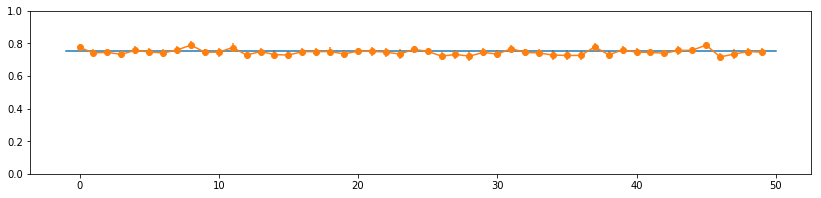

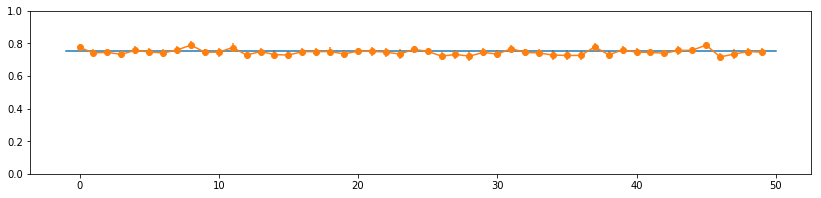

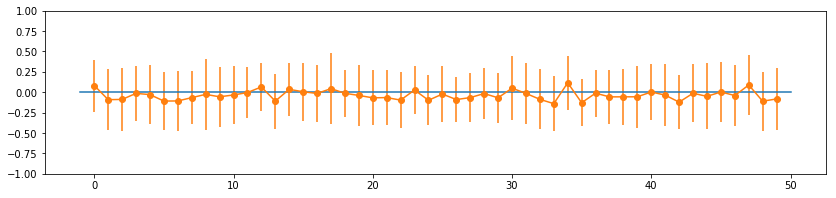

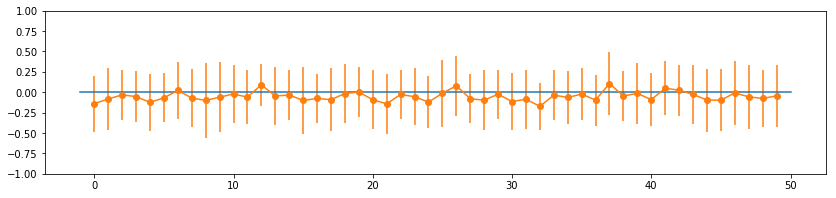

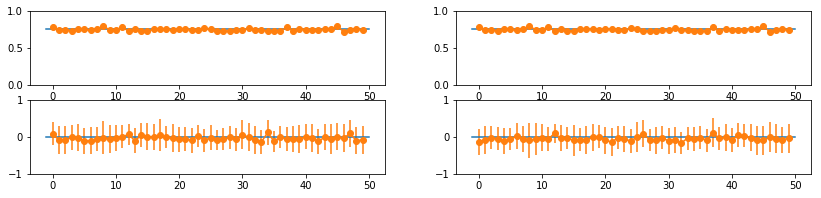

In [6]:
hist = [get_samples(100) for ii in range(50)]

plot_coverage(hist, dim=0, target=0.75)
plot_coverage(hist, dim=1, target=0.75)

plot_centering(hist, dim=0)
plot_centering(hist, dim=1)

plot_distrib(hist)

In [7]:
LR = 1e-5
BSIZE = 64
bhalf = BSIZE // 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
real_labels = Variable(torch.ones(bhalf, 1), requires_grad=False).to(device)
fake_labels = Variable(torch.zeros(bhalf, 1), requires_grad=False).to(device)
device

device(type='cuda', index=0)

In [8]:
spawn = SpawnNet(hsize=4, zsize=4).to(device)
discrim = DiscrimNet(hsize=4).to(device)

gen_opt = optim.Adam([
    { 'params': spawn.parameters() },
], lr=LR)

discrim_opt = optim.Adam([
    { 'params': discrim.parameters() },
], lr=LR)

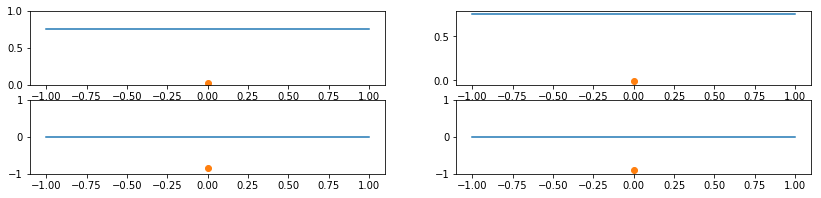

In [9]:
def sample_fakes():
    fake_samples = []
    bases = get_samples(100, baseonly=True)
    for stack in bases:
        zvar = spawn.init_noise(size=4).to(device)
        hp = stack[0].to(device)
        zout = spawn(hp, zvar)
        fake_samples.append(stack + [zout.cpu()])
    return fake_samples

history=[sample_fakes()]
plot_distrib(history)

In [11]:
history=[]
n_iters = 500 * 1000

for iter in range(1, n_iters + 1):
    spawn.train()
    discrim.train()
    
    discrim_opt.zero_grad()

    real_samples = get_samples(bhalf, concat=True, device=device)
    real_samples = torch.stack(real_samples).to(device)
    just_bases = get_samples(bhalf, baseonly=True, device=device)
    fake_samples = []
    for stack in just_bases:
        zvar = spawn.init_noise(size=4).to(device)
        hp = stack[0]
        hchild = spawn(hp, zvar)
        fake_samples.append(torch.cat(stack + [hchild], -1).to(device))
    fake_samples = torch.stack(fake_samples).to(device)
    
    # -- Discrimination Training --
    real_guesses = discrim(real_samples, sigmoid=False)
    fake_guesses = discrim(fake_samples.detach(), sigmoid=False)
    # loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
    discrim_loss = -torch.mean(real_guesses) + torch.mean(fake_guesses)
    discrim_loss.backward()
    discrim_opt.step()
    for p in discrim.parameters():
        p.data.clamp_(-0.01, 0.01)
    
    real_score = score(real_guesses, real_labels)
    fake_score = score(fake_guesses, fake_labels)
    disc_score = (real_score + fake_score) / 2
    assert disc_score <= 1.0
    
    if iter % 5 == 0:
        fake_samples = []
        just_bases = get_samples(bhalf, baseonly=True, device=device)
        for stack in just_bases:
            zvar = spawn.init_noise(size=4).to(device)
            hp = stack[0]
            hchild = spawn(hp, zvar)
            fake_samples.append(torch.cat(stack + [hchild], -1).to(device))
        fake_samples = torch.stack(fake_samples).to(device)
        
        # -- Generator Training --
        gen_opt.zero_grad()
        # loss_G = -torch.mean(discriminator(gen_imgs))
        gen_loss = -torch.mean(discrim(fake_samples, sigmoid=False))
        gen_loss.backward()
        gen_opt.step()

    if iter % 10 == 0:
        sys.stdout.write('[%d] Generate/L: %.5f  Discrim/L : %.5f  Score: %.2f   \r' % (
            iter,
            gen_loss.item(),
            discrim_loss.item(),
            disc_score))
    
    if iter % 100 == 0:
        spawn.eval()
        discrim.eval()
        preview = sample_fakes()
        history.append(preview)

    if iter % 5000 == 0:        
        plot_distrib(history, recent=30)


KeyboardInterrupt: 

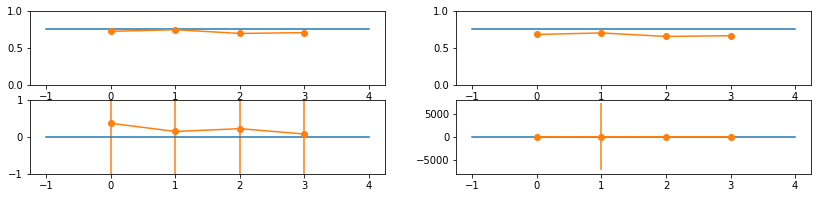

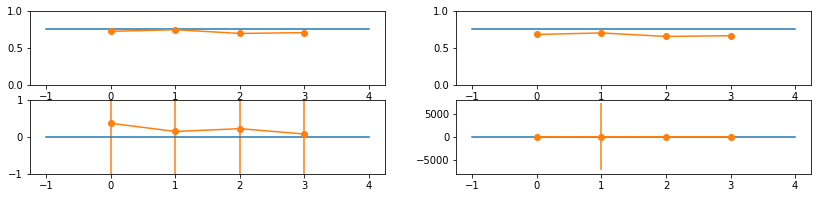

In [12]:
plot_distrib(history)
plot_distrib(history, recent=50)

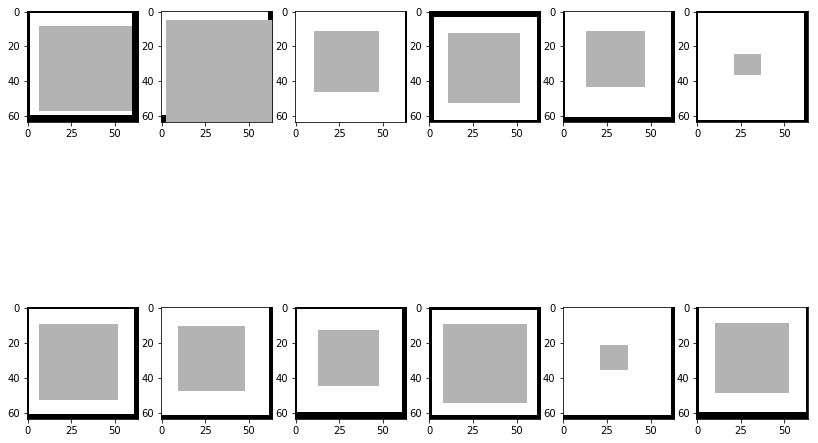

In [13]:
plt.figure(figsize=(14, 10))
for jj in range(2):
    for ii in range(spreview):
        ind = spreview*jj+ii
        plt.subplot(2, spreview, ind+1)
        plt.imshow(raster(history[-1][ind]), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()

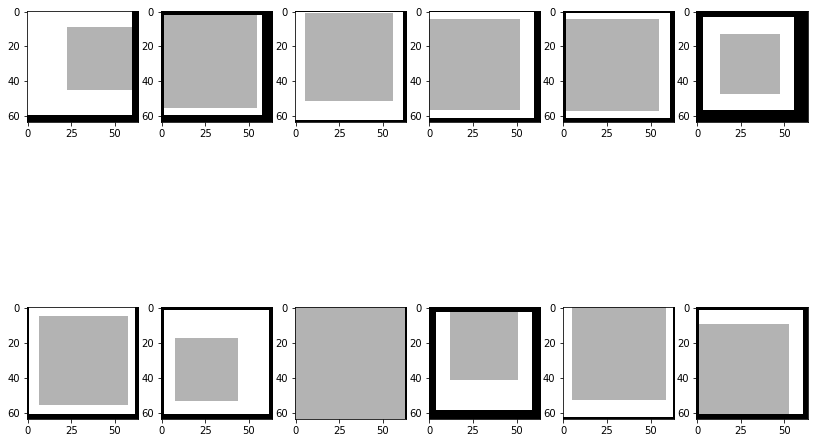

In [14]:
real_samples = get_samples(50)
plt.figure(figsize=(14, 10))
for jj in range(2):
    for ii in range(spreview):
        ind = spreview*jj+ii
        plt.subplot(2, spreview, ind+1)
        plt.imshow(raster(real_samples[ind]), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.close()